Analyzing data coming from the script: 

C:\Users\David\Documents\GitHub\encoding\scripts\wm_representation\functions\IEM\Controls\trial_by_trial\trainT_testT_wm3.py

In [1]:
from linares_plot import *
import sys, os
import statsmodels.formula.api as smf
path_tools = 'C:\\Users\\David\\Documents\\GitHub\\encoding\\scripts\\wm_representation\\functions\\IEM\\tools'
sys.path.insert(1, path_tools)
from timecourse import *
from timecourse_c import *
from scipy import stats
from mlxtend.evaluate import permutation_test

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
recons_path =  'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\recs_IEM_trainT_testT_wm3.npy' 

Reconstructions = np.load(recons_path, encoding='latin1')

print(np.shape(Reconstructions))
print(np.shape(Reconstructions[10]))

(24,)
(372, 16, 720)


In [4]:
beh_path =  'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\trainT_testT_behaviour.xlsx' 
xl = pd.ExcelFile(beh_path)
sheet_names = xl.sheet_names

print(len(sheet_names))
beh_x = pd.read_excel(beh_path, sheet_name=sheet_names[10])
print(np.shape(beh_x))

24
(372, 46)


In [5]:
## Indexes equivalences

Subjects=['d001', 'n001', 'b001', 'r001', 's001', 'l001']
brain_regions = ['visual','ips', 'pfc', 'broca']

index = 0
for Subject in Subjects:
    for Brain_region in brain_regions:
        print(index, Subject, Brain_region)
        index += 1
        


0 d001 visual
1 d001 ips
2 d001 pfc
3 d001 broca
4 n001 visual
5 n001 ips
6 n001 pfc
7 n001 broca
8 b001 visual
9 b001 ips
10 b001 pfc
11 b001 broca
12 r001 visual
13 r001 ips
14 r001 pfc
15 r001 broca
16 s001 visual
17 s001 ips
18 s001 pfc
19 s001 broca
20 l001 visual
21 l001 ips
22 l001 pfc
23 l001 broca


#### Plot heatmap of one condition in one subject

In [9]:
idx_ = 4 ##  0 --> n001 visual

reconstr_trials = np.array(Reconstructions[idx_])
beh =  pd.read_excel(beh_path, sheet_name=sheet_names[idx_])

print(np.shape(reconstr_trials))
print(np.shape(beh))

(372, 16, 720)
(372, 46)


372
96
(96, 16, 720)
(16, 720)


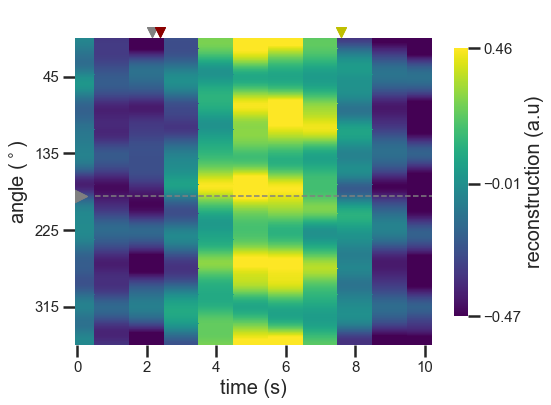

In [10]:
Condition_ = '1_0.2'
bool_condition = np.array(beh.Condition==Condition_)
print(len(bool_condition))
print(sum(bool_condition))

reconstr_trials_cond = reconstr_trials[bool_condition]
print(np.shape(reconstr_trials_cond))

mean_reconstr_cond = reconstr_trials_cond.mean(axis=0)
print(np.shape(mean_reconstr_cond))


dfx = pd.DataFrame(mean_reconstr_cond.T)

Representation_heatmap(dfx, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

#### Plot a condition, all subjects

In [194]:
Condition_ = '1_0.2'
idx_visual = [0,4,8,12,16,20]
idx_ips = [1,5,9,13,17,21]
idx_pfc = [2,6,10,14,18,22]
idx_broca = [3,7,11,15,19,23]

idx_area = idx_broca

frames=[]

for idx_ in idx_area:
    reconstr_trials = np.array(Reconstructions[idx_])
    beh =  pd.read_excel(beh_path, sheet_name=sheet_names[idx_])
    #
    bool_condition = np.array(beh.Condition==Condition_)
    reconstr_trials_cond = reconstr_trials[bool_condition]
    #
    mean_reconstr_cond = reconstr_trials_cond.mean(axis=0)
    #
    dfx = pd.DataFrame(mean_reconstr_cond.T) ## it could be done another way, but this is probably the most correct (all count the same)ç
    #
    frames.append(dfx)



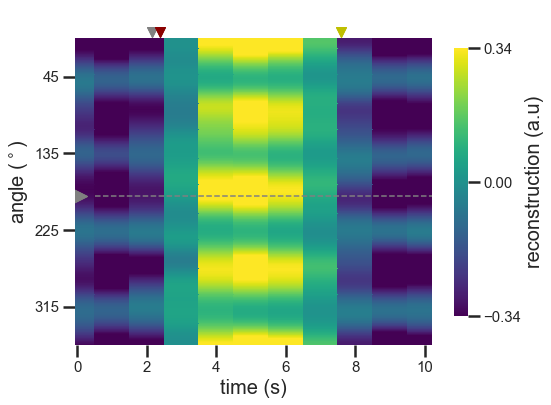

In [173]:
dfx_ = pd.concat(frames).groupby(level=0).mean()
Representation_heatmap(dfx_, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

### Shuffle (pick randomly one of the 3 targets)

In [ ]:
n_shuffles=10

Condition_ = '2_7'
idx_visual = [0,4,8,12,16,20]
idx_ips = [1,5,9,13,17,21]
idx_pfc = [2,6,10,14,18,22]
idx_broca = [3,7,11,15,19,23]

frames_sh = []

for idx_ in idx_area:
    reconstr_trials = np.array(Reconstructions[idx_])
    beh =  pd.read_excel(beh_path, sheet_name=sheet_names[idx_])
    #
    bool_condition = np.array(beh.Condition==Condition_)
    reconstr_trials_cond = reconstr_trials[bool_condition]
    reconstr_beh_cond = beh[bool_condition]
    #
    shuffled = []
    for ix in range(n_shuffles): ## no lo hago solo una vez! con 10 ya es bastante estable
        for trial in range(len(reconstr_beh_cond)):
            reconstr_tr_x = reconstr_trials_cond[trial]
            angle_trial = reconstr_beh_cond['T_alone'].iloc[trial]
            to_roll_back = int( (180 - angle_trial)*(720/360) ) ## degrees to roll
            reconstr_rolled_back = np.roll(reconstr_trials_cond[trial],-to_roll_back, axis=0)
            ###
            ##align to other 
            ## 1 - Other target! (makes no sense! all equally relevant!)
            rch = np.random.choice([0,1,2]) ## T_alone es igual a a A_DVF, por lo que alineo a uno de los otros 2
            if rch == 0:
                colu_ = 'A_DC'
            elif rch == 1:
                colu_ = 'A_DF'
            elif rch == 2:
                colu_ = 'A_DVF'

            new_angle = reconstr_beh_cond[colu_].iloc[trial]
            to_roll = int( (180 - new_angle)*(720/360) ) ## degrees to roll
            reconstr_rolled_shuff = np.roll(reconstr_rolled_back, to_roll, axis=0)
            shuffled.append(reconstr_rolled_shuff)
    ###
    # Mean de shuffles
    Shuffles= np.array(shuffled)
    print(np.shape(Shuffles))
    mean_reconstr_shuffled_cond = Shuffles.mean(axis=0)
    #
    dfx = pd.DataFrame(mean_reconstr_shuffled_cond.T) ## it could be done another way, but this is probably the most correct (all count the same)ç
    #
    frames_sh.append(dfx)
    
        
        
        
        

In [ ]:
dfx_sh = pd.concat(frames_sh).groupby(level=0).mean()
Representation_heatmap(dfx_sh, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [ ]:
substr_shuffle = dfx_ - dfx_sh
Representation_heatmap(substr_shuffle, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [ ]:
plt.plot(dfx_.iloc[:,:3].mean(axis=1).values, color='r', label='signal')
plt.plot(dfx_sh.iloc[:,:3].mean(axis=1).values, color='b', label='shuffle')
plt.plot(substr_shuffle.iloc[:,:3].mean(axis=1).values, color='g', label='substraction')
plt.ylim(-0.5, 0.25)
plt.legend(fontsize=12, frameon=False)

In [ ]:
plt.plot(substr_shuffle.iloc[360-10:360+10, :].mean(axis=0))

### Shuffle (pick randomly one of the other 2 targets)

In [ ]:
n_shuffles=10

Condition_ = '2_7'
idx_visual = [0,4,8,12,16,20]
idx_ips = [1,5,9,13,17,21]
idx_pfc = [2,6,10,14,18,22]
idx_broca = [3,7,11,15,19,23]

frames_sh = []

for idx_ in idx_area:
    reconstr_trials = np.array(Reconstructions[idx_])
    beh =  pd.read_excel(beh_path, sheet_name=sheet_names[idx_])
    #
    bool_condition = np.array(beh.Condition==Condition_)
    reconstr_trials_cond = reconstr_trials[bool_condition]
    reconstr_beh_cond = beh[bool_condition]
    #
    shuffled = []
    for ix in range(n_shuffles): ## no lo hago solo una vez! con 10 ya es bastante estable
        for trial in range(len(reconstr_beh_cond)):
            reconstr_tr_x = reconstr_trials_cond[trial]
            angle_trial = reconstr_beh_cond['T_alone'].iloc[trial]
            to_roll_back = int( (180 - angle_trial)*(720/360) ) ## degrees to roll
            reconstr_rolled_back = np.roll(reconstr_trials_cond[trial],-to_roll_back, axis=0)
            ###
            ##align to other 
            ## 1 - Other target! (makes no sense! all equally relevant!)
            rch = np.random.choice([0,1]) ## T_alone es igual a a A_DVF, por lo que alineo a uno de los otros 2
            if rch == 0:
                colu_ = 'A_DC'
            elif rch == 1:
                colu_ = 'A_DF'
                
            new_angle = reconstr_beh_cond[colu_].iloc[trial]
            to_roll = int( (180 - new_angle)*(720/360) ) ## degrees to roll
            reconstr_rolled_shuff = np.roll(reconstr_rolled_back, to_roll, axis=0)
            shuffled.append(reconstr_rolled_shuff)
    ###
    # Mean de shuffles
    Shuffles= np.array(shuffled)
    print(np.shape(Shuffles))
    mean_reconstr_shuffled_cond = Shuffles.mean(axis=0)
    #
    dfx = pd.DataFrame(mean_reconstr_shuffled_cond.T) ## it could be done another way, but this is probably the most correct (all count the same)ç
    #
    frames_sh.append(dfx)
    
        
        
        
        

In [ ]:
dfx_sh = pd.concat(frames_sh).groupby(level=0).mean()
Representation_heatmap(dfx_sh, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [ ]:
substr_shuffle = dfx_ - dfx_sh
Representation_heatmap(substr_shuffle, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [ ]:
plt.plot(dfx_.iloc[:,:3].mean(axis=1).values, color='r', label='signal')
plt.plot(dfx_sh.iloc[:,:3].mean(axis=1).values, color='b', label='shuffle')
plt.plot(substr_shuffle.iloc[:,:3].mean(axis=1).values, color='g', label='substraction')
plt.ylim(-0.5, 0.25)
plt.legend(fontsize=12, frameon=False)

In [ ]:
plt.plot(substr_shuffle.iloc[360-10:360+10, :].mean(axis=0))

### Shuffle (pick a random location 1-360)

In [ ]:
n_shuffles=10

Condition_ = '2_7'
idx_visual = [0,4,8,12,16,20]
idx_ips = [1,5,9,13,17,21]
idx_pfc = [2,6,10,14,18,22]
idx_broca = [3,7,11,15,19,23]

frames_sh = []

for idx_ in idx_area:
    reconstr_trials = np.array(Reconstructions[idx_])
    beh =  pd.read_excel(beh_path, sheet_name=sheet_names[idx_])
    #
    bool_condition = np.array(beh.Condition==Condition_)
    reconstr_trials_cond = reconstr_trials[bool_condition]
    reconstr_beh_cond = beh[bool_condition]
    #
    shuffled = []
    for ix in range(n_shuffles): ## no lo hago solo una vez! con 10 ya es bastante estable
        for trial in range(len(reconstr_beh_cond)):
            reconstr_tr_x = reconstr_trials_cond[trial]
            angle_trial = reconstr_beh_cond['T_alone'].iloc[trial]
            to_roll_back = int( (180 - angle_trial)*(720/360) ) ## degrees to roll
            reconstr_rolled_back = np.roll(reconstr_trials_cond[trial],-to_roll_back, axis=0)
            ###
            ##align to other 
            ## 1 - Random location 1-360
            new_angle = np.random.randint(0,359)
            to_roll = int( (180 - new_angle)*(720/360) ) ## degrees to roll
            reconstr_rolled_shuff = np.roll(reconstr_rolled_back, to_roll, axis=0)
            shuffled.append(reconstr_rolled_shuff)
    ###
    # Mean de shuffles
    Shuffles= np.array(shuffled)
    print(np.shape(Shuffles))
    mean_reconstr_shuffled_cond = Shuffles.mean(axis=0)
    #
    dfx = pd.DataFrame(mean_reconstr_shuffled_cond.T) ## it could be done another way, but this is probably the most correct (all count the same)ç
    #
    frames_sh.append(dfx)
    

In [ ]:
dfx_sh = pd.concat(frames_sh).groupby(level=0).mean()
Representation_heatmap(dfx_sh, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [ ]:
substr_shuffle = dfx_ - dfx_sh
Representation_heatmap(substr_shuffle, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [ ]:
plt.plot(dfx_.iloc[:,:3].mean(axis=1).values, color='r', label='signal')
plt.plot(dfx_sh.iloc[:,:3].mean(axis=1).values, color='b', label='shuffle')
plt.plot(substr_shuffle.iloc[:,:3].mean(axis=1).values, color='g', label='substraction')
plt.ylim(-0.5, 0.25)
plt.legend(fontsize=12, frameon=False)

In [ ]:
plt.plot(substr_shuffle.iloc[360-10:360+10, :].mean(axis=0))

### Shuffle (pick a random inside the free quadrant)

In [ ]:
n_shuffles=10

Condition_ = '2_7'
idx_visual = [0,4,8,12,16,20]
idx_ips = [1,5,9,13,17,21]
idx_pfc = [2,6,10,14,18,22]
idx_broca = [3,7,11,15,19,23]

frames_sh = []

for idx_ in idx_area:
    reconstr_trials = np.array(Reconstructions[idx_])
    beh =  pd.read_excel(beh_path, sheet_name=sheet_names[idx_])
    #
    bool_condition = np.array(beh.Condition==Condition_)
    reconstr_trials_cond = reconstr_trials[bool_condition]
    reconstr_beh_cond = beh[bool_condition]
    #
    shuffled = []
    for ix in range(n_shuffles): ## no lo hago solo una vez! con 10 ya es bastante estable
        for trial in range(len(reconstr_beh_cond)):
            reconstr_tr_x = reconstr_trials_cond[trial]
            angle_trial = reconstr_beh_cond['T_alone'].iloc[trial]
            to_roll_back = int( (180 - angle_trial)*(720/360) ) ## degrees to roll
            reconstr_rolled_back = np.roll(reconstr_trials_cond[trial],-to_roll_back, axis=0)
            ###
            ##align to other 
            ## 3- random in quadrant alone
            q_alone = list(set([1,2,3,4]) - set([reconstr_beh_cond['Q_DC'].iloc[trial], reconstr_beh_cond['Q_DF'].iloc[trial], reconstr_beh_cond['Q_DVF'].iloc[trial]]))[0]
            if q_alone==1:
                new_angle = np.random.randint(0,89)
            if q_alone==2:
                new_angle = np.random.randint(90,179)
            if q_alone==3:
                new_angle = np.random.randint(180, 269)
            if q_alone==4:
                new_angle = np.random.randint(270, 359)
            ##
            ##                
            to_roll = int( (180 - new_angle)*(720/360) ) ## degrees to roll
            reconstr_rolled_shuff = np.roll(reconstr_rolled_back, to_roll, axis=0)
            shuffled.append(reconstr_rolled_shuff)
    ###
    # Mean de shuffles
    Shuffles= np.array(shuffled)
    print(np.shape(Shuffles))
    mean_reconstr_shuffled_cond = Shuffles.mean(axis=0)
    #
    dfx = pd.DataFrame(mean_reconstr_shuffled_cond.T) ## it could be done another way, but this is probably the most correct (all count the same)ç
    #
    frames_sh.append(dfx)
    

In [ ]:
dfx_sh = pd.concat(frames_sh).groupby(level=0).mean()
Representation_heatmap(dfx_sh, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [ ]:
substr_shuffle = dfx_ - dfx_sh
Representation_heatmap(substr_shuffle, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [ ]:
plt.plot(dfx_.iloc[:,:3].mean(axis=1).values, color='r', label='signal')
plt.plot(dfx_sh.iloc[:,:3].mean(axis=1).values, color='b', label='shuffle')
plt.plot(substr_shuffle.iloc[:,:3].mean(axis=1).values, color='g', label='substraction')
plt.ylim(-0.5, 0.25)
plt.legend(fontsize=12, frameon=False)

In [ ]:
plt.plot(substr_shuffle.iloc[360-10:360+10, :].mean(axis=0))

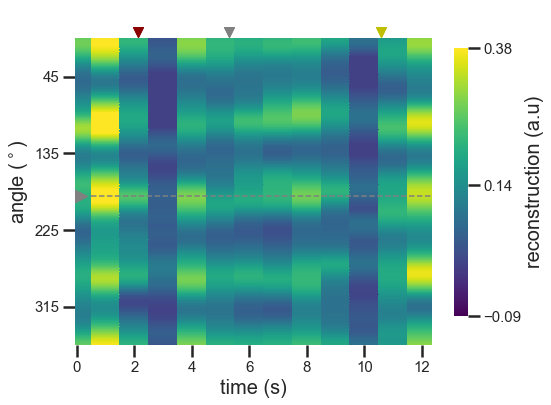

In [151]:
dfx3 = substr_shuffle.copy()

for col in range(np.shape(dfx)[1]):
    dfx3.iloc[:, col] = Pos_IEM2(substr_shuffle.iloc[:,col].values) 


Representation_heatmap(dfx3, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

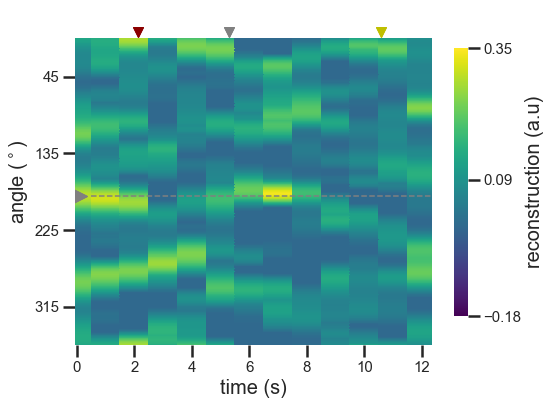

In [79]:
dfx3 = substr_shuffle.copy()

for col in range(np.shape(dfx)[1]):
    dfx3.iloc[:, col] = Pos_IEM2(dfx.iloc[:,col].values) 


Representation_heatmap(dfx3, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

(-0.5, 0.25)

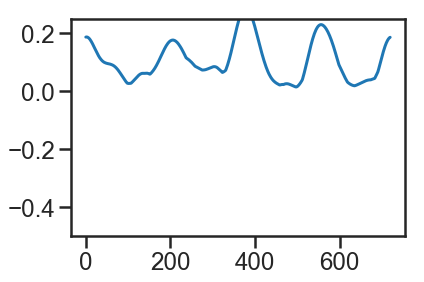

In [80]:
plt.plot(dfx3.iloc[:,:3].mean(axis=1).values)
plt.ylim(-0.5, 0.25)

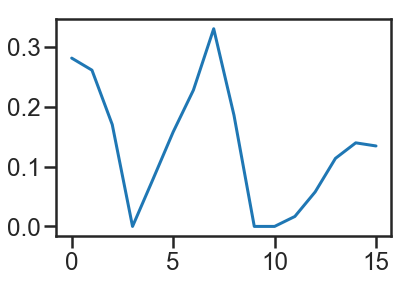

In [81]:
plt.plot(dfx3.iloc[360, :])

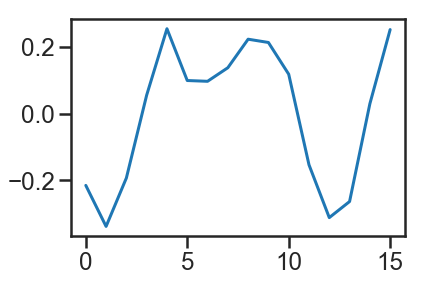

In [52]:
plt.plot(substr_shuffle.iloc[360, :])

In [13]:
### Methods de reconstruction

In [14]:
## default

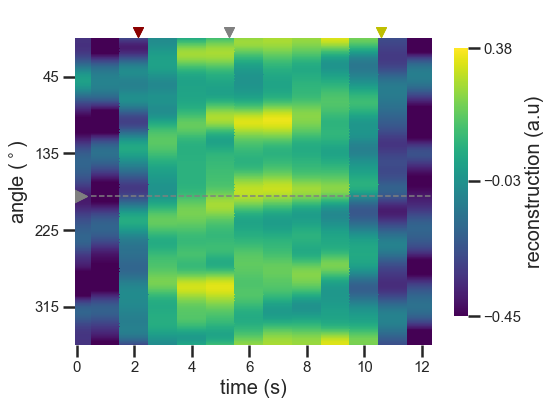

In [15]:
Representation_heatmap(dfx, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [ ]:
##substract the weight matrix structure in each TR

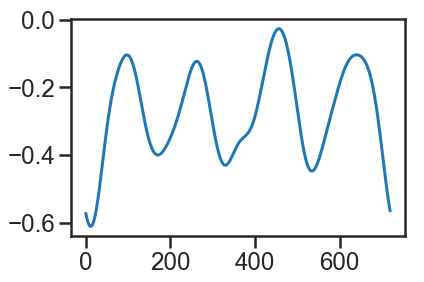

In [155]:
plt.plot(dfx.iloc[:,:3].mean(axis=1).values)

In [156]:
substr_structure = dfx.iloc[:,:3].mean(axis=1).values
dfx2 = dfx.copy()

for col in range(np.shape(dfx)[1]):
    dfx2.iloc[:, col] = dfx.iloc[:, col] - substr_structure

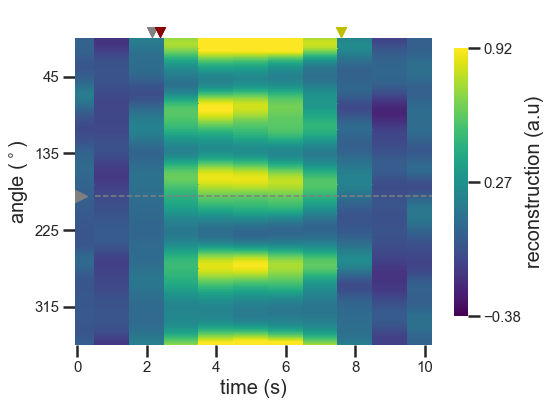

In [157]:
Representation_heatmap(dfx2, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [ ]:
##Apply the POS function to each TR

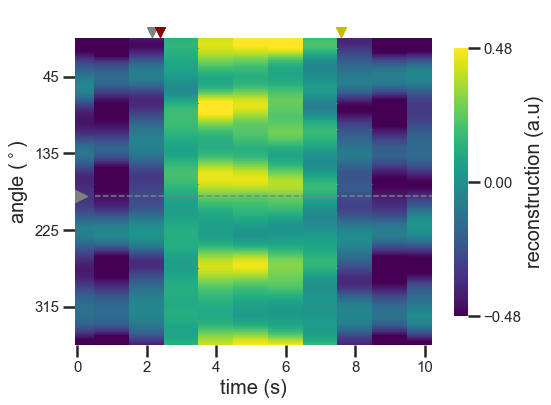

In [160]:
Representation_heatmap(dfx, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

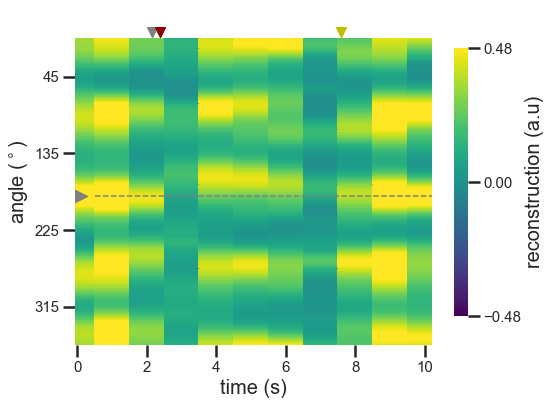

In [163]:
dfx3 = dfx.copy()

for col in range(np.shape(dfx)[1]):
    dfx3.iloc[:, col] = Pos_IEM2(dfx.iloc[:,col].values) 


Representation_heatmap(dfx3, condition=Condition_, max_ = 0.48, min_= -0.48, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

In [ ]:
###it did not go exactly in the direction I expected!!! meh...

In [130]:
dfx

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.327216,-0.490157,-0.270901,-0.049685,0.055542,0.125394,0.245421,0.273012,0.251227,0.333764,0.205860,-0.253796,-0.672858,-0.574803,-0.079581,0.297343
1,-0.327655,-0.494599,-0.279045,-0.050284,0.062150,0.131840,0.247869,0.273214,0.250580,0.332086,0.203442,-0.256118,-0.673018,-0.574084,-0.079789,0.297664
2,-0.328200,-0.498994,-0.287191,-0.050742,0.068955,0.138324,0.250150,0.273310,0.249787,0.330053,0.200865,-0.258331,-0.672858,-0.573115,-0.079973,0.297908
3,-0.328666,-0.503065,-0.295045,-0.050966,0.075984,0.144788,0.252057,0.273131,0.248763,0.327508,0.197984,-0.260368,-0.672046,-0.571367,-0.080010,0.297740
4,-0.329265,-0.507121,-0.302893,-0.050934,0.083340,0.151322,0.253798,0.272927,0.247649,0.324495,0.194728,-0.262460,-0.670945,-0.569281,-0.079870,0.297644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-0.325168,-0.466495,-0.229603,-0.043482,0.027220,0.094664,0.229771,0.269681,0.251676,0.334115,0.212667,-0.240940,-0.664979,-0.569871,-0.075446,0.293197
716,-0.325546,-0.471436,-0.237863,-0.045061,0.032250,0.100565,0.233313,0.270671,0.251989,0.335070,0.211925,-0.243783,-0.667528,-0.571877,-0.076587,0.294407
717,-0.325860,-0.476138,-0.246094,-0.046521,0.037559,0.106565,0.236613,0.271438,0.252017,0.335469,0.210873,-0.246429,-0.669456,-0.573249,-0.077519,0.295387
718,-0.326360,-0.481036,-0.254424,-0.047819,0.043216,0.112782,0.239803,0.272194,0.252035,0.335455,0.209522,-0.248985,-0.671113,-0.574330,-0.078332,0.296195


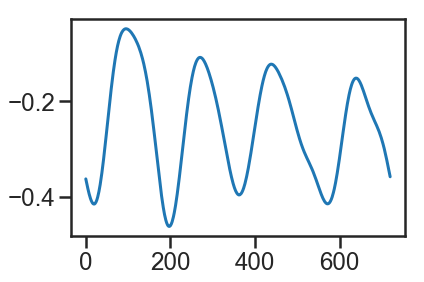

In [146]:
# substract to each column??



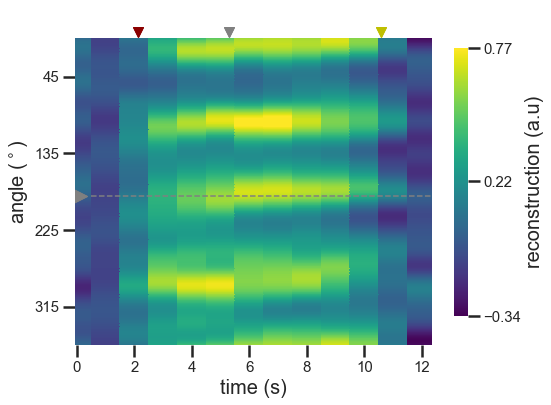

In [149]:
Representation_heatmap(dfx2, condition=Condition_, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15)

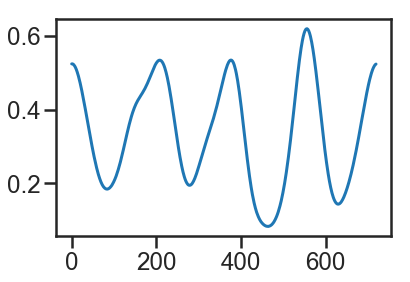

In [136]:
posx = Pos_IEM2(dfx.iloc[:,1].values)
plt.plot(posx)

In [ ]:
## Apply the POS to the final recosntruction

In [ ]:
## Apply the POS to each trial reconstruction and mean the final one

In [7]:
sep_channels=10
adjusted_size_contant = 48.519

pos_channels = np.arange(sep_channels/2,360,sep_channels)
pos_channels = [round(pos_channels[i],3) for i in range(0, len(pos_channels))]

pos_channels2 = np.arange(0,360,0.5)
pos_channels2 = [round(pos_channels2[i],3) for i in range(0, len(pos_channels2))]

def posch1_to_posch2(ch_1):
    return np.where(np.array(pos_channels2) == pos_channels[ch_1])[0][0]


def Representation_heatmap(df, condition='1_0.2', min_=None, max_=None, ref_angle=180, TR=2.335, bin_=0.5, fs1=20, fs2=15):
    ##
    ##
    ##### pal_cyan = sns.color_palette("RdBu_r", n_colors=200)[40:] #RdBu_r
    pal_cyan = 'viridis'
    #
    if min_==None:
        min_ = np.round(df.mean().mean()-4*df.std().mean(),2)
    if max_==None:
        max_ = np.round(df.mean().mean()+4*df.std().mean(),2)
    #
    middle = np.round( min_ + ((abs(max_)+abs(min_))/2), 2)
    ##
    ##
    
    plt.figure(figsize=(8,6))
    ax = sns.heatmap(df, cmap=pal_cyan, 
                     vmin=min_, 
                     vmax=max_,
                     cbar=True, 
                cbar_kws={"shrink": .82, 'ticks' : [min_, middle, max_], 'label': 'reconstruction (a.u)'})
    ax.figure.axes[-1].yaxis.label.set_size(fs1)
    ax.figure.axes[-1].tick_params(labelsize=fs2)
    
    plt.gca().set_ylabel('')
    plt.yticks([posch1_to_posch2(4), posch1_to_posch2(13), posch1_to_posch2(22), posch1_to_posch2(31)],['45','135','225', '315'])

    dims=np.shape(df)
    dimN = dims[0]
    plt.gca().set_ylim(dimN, -45)
    
    plt.plot([0.5, 0.5], [posch1_to_posch2(18),posch1_to_posch2(18)], markersize=20, color='grey', marker='>')
    plt.plot([1, 23.5], [posch1_to_posch2(18),posch1_to_posch2(18)], color='grey', linestyle='--', linewidth=1.5)
    
    ################################
    presentation_period= 0.35 #stim presnetation time
    presentation_period_cue=  0.50 #presentation of attentional cue time
    pre_stim_period= 0.5 #time between cue and stim
    resp_time = 4  #time the response is active
    start_hrf = 4  #start of the Hemodynamic response (4seconds)
    if condition == '1_0.2':
        condition_title = 'o:1, d:0.2'
        delay1 = 0.2
        delay2 = 11.8
        cue=0
        t_p = cue + presentation_period_cue + pre_stim_period 
        d_p = t_p + presentation_period +delay1 
        r_t = d_p + presentation_period + delay2
        xlim = [1/TR, 25/TR]
    elif condition=='1_7':
        condition_title = 'o:1, d:7'
        delay1 = 7
        delay2 = 5
        cue=0
        t_p = cue + presentation_period_cue + pre_stim_period 
        d_p = t_p + presentation_period +delay1 
        r_t = d_p + presentation_period + delay2
        xlim = [1/TR, 25/TR]
    elif condition=='2_0.2':
        condition_title = 'o:2, d:0.2'
        delay1 = 0.2
        delay2 = 12
        cue=0
        d_p = cue + presentation_period_cue + pre_stim_period 
        t_p = d_p + presentation_period +delay1 
        r_t = t_p + presentation_period + delay2   
        xlim = [1/TR, 25/TR]
    elif condition=='2_7':
        condition_title = 'o:2, d:7'
        delay1 = 7
        delay2 = 12
        cue=0
        d_p = cue + presentation_period_cue + pre_stim_period 
        t_p = d_p + presentation_period +delay1 
        r_t = t_p + presentation_period + delay2
        xlim = [1/TR, 30/TR]
    ##
    ##
    t_p1 = (start_hrf + t_p) ## strat of target (time)
    d_p1 = (start_hrf + d_p) ##strat of didtractor (time)
    r_p1=  (start_hrf + r_t) ## start of response (time)
    ##
    plt.plot([t_p1/TR +bin_,t_p1/TR+bin_], [-15,-15], markersize=10, color='grey', marker='v')
    plt.plot([d_p1/TR +bin_,d_p1/TR+bin_], [-15,-15], markersize=10, color='darkred', marker='v')
    plt.plot([r_p1/TR +bin_,r_p1/TR+bin_], [-15,-15], markersize=10, color='y', marker='v')
    plt.gca().set_xlim(xlim)
    
    plt.xticks(fontsize=fs2)
    plt.yticks(fontsize=fs2)
    plt.gca().set_ylabel('angle ($^\circ$)', fontsize=fs1)
    plt.gca().set_xlabel('time (s)', fontsize=fs1)
    #plt.title(condition_title)
    
    plt.show()


In [8]:
def Pos_IEM2( channel_reconstruction ):
    # make it all positive
    # negative values are positive in somwhere else
    all_channels = list(np.arange(0, len(channel_reconstruction), 1))
    half_ = len(all_channels)/2
    new_ = np.zeros((len(all_channels)))
    #
    POS_channel_reconstruction = list(channel_reconstruction)
    #
    all_channels=list(all_channels)
    #
    #
    for ch in all_channels:
        value_ch = POS_channel_reconstruction[ch]
        if value_ch>0:
            new_[ch] = new_[ch] + value_ch
        if value_ch<0:            
            if ch<half_:
                new_[int(ch+half_)] = new_[int(ch+half_)] - value_ch
            if ch>=half_:
                new_[int(ch-half_)] = new_[int(ch-half_)] - value_ch
    ###
    return new_

